# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


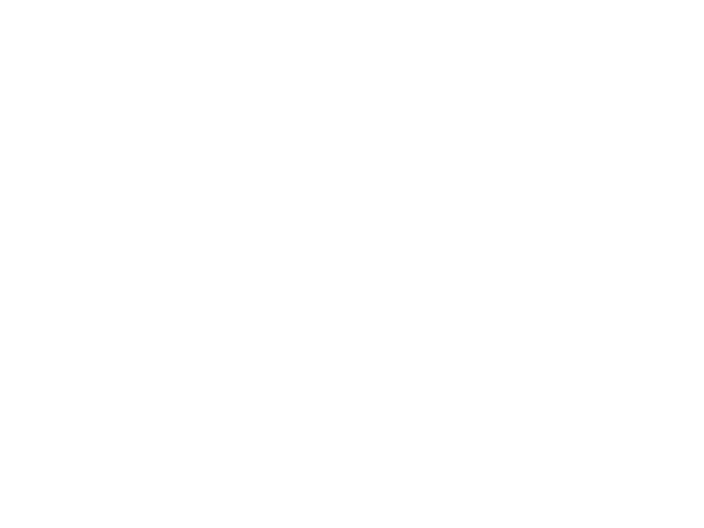

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


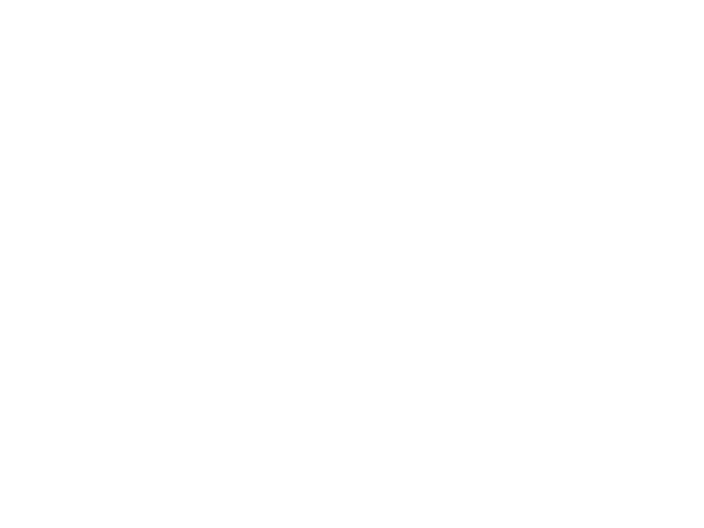

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


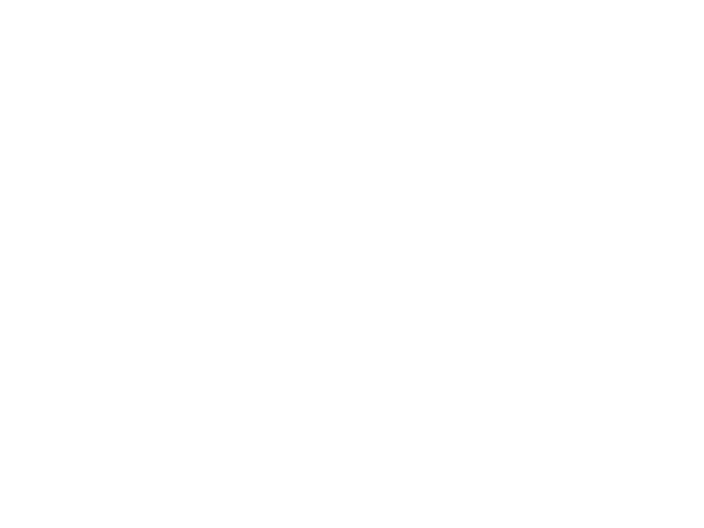

In [5]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


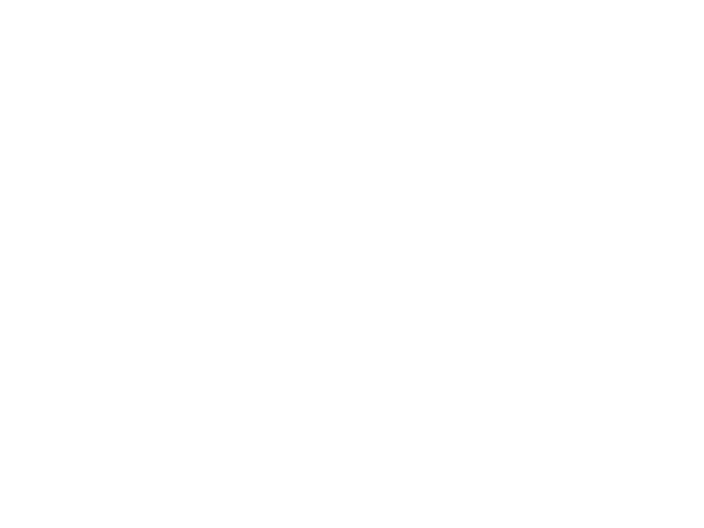

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

#### Type classes definition

In [7]:
from enum import Enum, auto
from random import uniform

eps = 10 ** (-9)

class Side(Enum):
    LEFT = auto()
    RIGHT = auto()    
    
class Orientation(Enum):
    LEFT = auto()
    COLLINEAR = auto()
    RIGHT = auto()

class Point:
    def __init__(self, x, y, side : Side = None, end = None):
        self.x = x
        self.y = y
        self.side = side
        self.end = end
    
    def set_end(self, other):
        self.end = other
    
    ### For printing and visualization
    
    def __str__(self):
        return f"({self.x}, {self.y}), side = {self.side}"

    def to_tuple(self):
        return self.x, self.y

    def to_line():
        if self.side == Side.LEFT:
            return [self.to_tuple(), self.end.to_tuple()]
        else:
            return [self.end.to_tuple(), self.to_tuple()]

In [8]:
def generate_random_lines(lower_left : Point, upper_right : Point, N):
    lines = []
        
    for _ in range(N):
        x1 = uniform(lower_left.x, upper_right.x)
        y1 = uniform(lower_left.y, upper_right.y)
    
        x2 = uniform(x1, upper_right.x)
        y2 = uniform(lower_left.y, upper_right.y)
        
        right = Point(x2, y2, Side.RIGHT)
        left = Point(x1, y1, Side.LEFT, right)
        
        right.set_end(left)
        
        lines.append([left, right])
    
    return lines

def parse_lines_collections(lines_collections):
    lines = []
    
    for lines_collection in lines_collections:
        for line in lines_collection.lines:
            a, b = line[0], line[1]
            dx = a[0] - b[0]
            
            if -eps <= dx <= eps:
                continue
            
            left, right = a, b
            if a[0] > b[0]:
                left, right = b, a
                
            rightP = Point(right[0], right[1], Side.RIGHT)
            leftP = Point(left[0], left[1], Side.LEFT, rightP)
            
            rightP.set_end(leftP)
            
            lines.append([leftP, rightP])
            
    return lines

def lines_to_point_tuples(lines):
    points = []
    
    for line in lines:
        left, right = line[0], line[1]
        
        points.append(left.to_tuple())
        points.append(right.to_tuple())
    
    return points

def lines_to_points(lines):
    points = []
    
    for line in lines:
        left, right = line[0], line[1]
        
        points.append(left)
        points.append(right)
        
    return points

def map_points_to_pairs(points):
    pairs = []
    
    for point in points:
        key, value = point.x, point
        pairs.append((key, value))
    
    return pairs

        

#### Helper Functions:
- determinant
- orientation

In [9]:
def det(a: Point, b: Point, c: Point):
    return a.x * b.y + a.x * c.x + b.x * c.y - b.y * c.x - a.x * c.y - a.y * b.x

def orient(a: Point, b: Point, c: Point):
    determinant = det(a, b, c)
    
    if determinant < -eps:
        return Orientation.RIGHT
    elif determinant > eps:
        return Orientation.LEFT
    else:
        return Orientation.COLLINEAR

#### Helper Functions:
- whether segments intersect
- point of intersection between two segments

In [39]:
# Given three collinear points p, q, r, this function checks if 
# point q lies on line segment 'pr' 
def on_segment(p: Point, q: Point, r: Point):
    return (max(p.x, r.x) >= q.x >= min(p.x, r.x) and 
        max(p.y, r.y) >= q.y >= min(p.y, r.y))

def do_intersect_points(p1: Point, q1: Point, p2: Point, q2: Point):
    line_a = [p1, q1]
    line_b = [p2, q2]
    
    return do_intersect_lines(line_a, line_b)
    
def do_intersect_lines(line_a, line_b):
    p1, q1 = line_a[0], line_a[1]
    p2, q2 = line_b[0], line_b[1]
    
    o1 = orient(p1, q1, p2); 
    o2 = orient(p1, q1, q2); 
    o3 = orient(p2, q2, p1); 
    o4 = orient(p2, q2, q1); 
  
    # General case 
    if o1 != o2 and o3 != o4: 
        return True 
  
    # Special Cases 
    # p1, q1 and p2 are collinear and p2 lies on segment p1q1 
    if o1 == Orientation.COLLINEAR and on_segment(p1, p2, q1):
        return True 
  
    # p1, q1 and q2 are collinear and q2 lies on segment p1q1 
    if o2 == Orientation.COLLINEAR and on_segment(p1, q2, q1):
        return True 
  
    # p2, q2 and p1 are collinear and p1 lies on segment p2q2 
    if o3 == Orientation.COLLINEAR and on_segment(p2, p1, q2):
        return True 
  
    # p2, q2 and q1 are collinear and q1 lies on segment p2q2 
    if o4 == Orientation.COLLINEAR and on_segment(p2, q1, q2):
        return True 
  
    return False # Doesn't fall in any of the above cases     
    
### Returns Point which is an intersection between two segments: AB and CD.
def lines_intersection(A: Point, B: Point, C: Point, D: Point):
        a1, b1 = B.y - A.y, A.x - B.x 
        c1 = a1 * A.x + b1 * A.y
       
        a2, b2 = D.y - C.y, C.x - D.x 
        c2 = a2 * C.x + b2 * C.y 
       
        determinant = a1 * b2 - a2 * b1
        x = (b2 * c1 - b1 * c2) / determinant 
        y = (a1 * c2 - a2 * c1) / determinant
            
        return Point(x, y) 

### Swiping algorithm

In [52]:
from sortedcontainers import SortedDict

def succ(T, p):
    keys = T.keys()
    i = keys.index(p.y)
    
    if len(keys) > i + 1:
        return T.get(keys[i + 1])
    else:
        return None

def pred(T, p):
    keys = T.keys()
    i = keys.index(p.y)
    
    if i > 0:
        return T.get(keys[0])
    else:
        return None

### Note that this might not work, we may want to recalcualte y depending
    ### on where we are...
def to_y_key_value_pair(point):
    key = point.y
    value = point

    return key, value
    
def swipe(lines):
    
    def first_case(Q, T, S, p):
        pair = to_y_key_value_pair(p)
        T.update([pair])

        s, r = pred(T, p), succ(T, p)
        if s != None:            
            if do_intersect_points(p, p.end, s, s.end):
                intersection = lines_intersection(p, p.end, s, s.end)
                Q.update([(intersection.x, intersection)])
        
        if r != None:
            pass
            
    def initalize_structures(lines):
        points = lines_to_points(lines)
        key_value_pairs = map_points_to_pairs(points)
        
        ### Insert all points into self-balanced tree 
        ### sorted by x - coord.
        Q = SortedDict(key_value_pairs)
        
        ### Empty T
        ### Key - y value of a line
        T = SortedDict()
        S = []
        
        return Q, T, S
    
    Q, T, S = initalize_structures(lines)
    
    while len(Q) > 0:
        _, p = Q.popitem(0)
        
        ### Three cases
        
        ## Case 1: p is left end of line segment 
        if p.side == Side.LEFT:
            first_case(Q, T, S, p)
        
    return S
    


In [54]:
def test():    
    l1 = Point(0.0, 0.0, Side.LEFT)
    r1 = Point(5.0, 5.0, Side.RIGHT, l1)
    l1.set_end(r1)
    
    l2 = Point(1.0, 2.0, Side.LEFT)
    r2 = Point(7.0, 3.0, Side.RIGHT, l2)
    l2.set_end(r2)
    
    lines = [[l1, r1], [l2, r2]]
    
    return lines


In [55]:
# lines = generate_random_lines(Point(0.0, 0.0, Side.LEFT), Point(1000.0, 1000.0, Side.RIGHT), 5)
lines = test()

print(swipe(lines))
    
    

[]


<IPython.core.display.Javascript object>


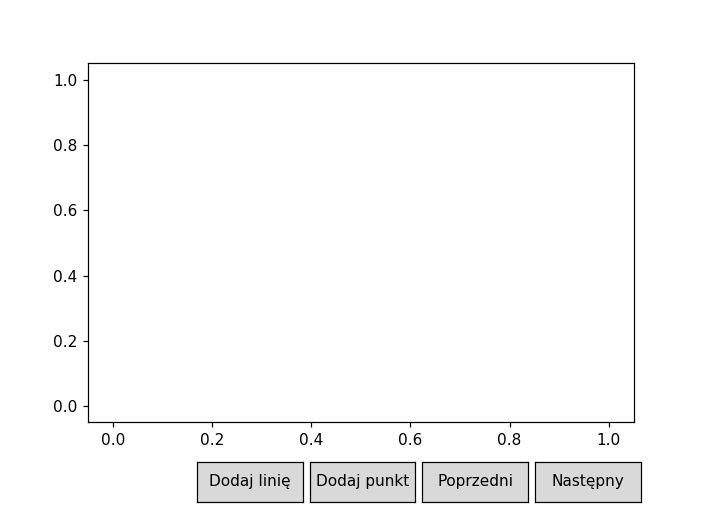

In [13]:
%matplotlib notebook

interactive_plot = Plot()
interactive_plot.draw()

In [14]:
lines_collections = interactive_plot.get_added_lines()

for lines_collection in lines_collections:
    for line in lines_collection.lines:
        print(line)
